# Сэтап фреймворка FastAi

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip install torchvision -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
!pip3 install torch torchvision torchaudio -q

In [ ]:
!pip install fastai -q

# Подготовка данных

Скачивание и распаковка датасета Cars Dataset от Stanford в директорию проекта

In [ ]:
!mkdir cardata && wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2023-04-13 17:58:43--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.84MB/s    in 0.2s    

2023-04-13 17:58:43 (1.84 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [ ]:
!tar -xzf car_devkit.tgz

In [ ]:
!mv devkit cardata/

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz

--2023-04-13 17:58:43--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  88.8MB/s    in 11s     

2023-04-13 17:58:55 (83.2 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
!tar -xzf cars_train.tgz

In [ ]:
!mv cars_train/ cardata/

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz

--2023-04-13 17:59:07--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  95.0MB/s    in 11s     

2023-04-13 17:59:17 (88.3 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [ ]:
!tar -xzf cars_test.tgz

In [ ]:
!mv cars_test/ cardata/

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat

--2023-04-13 17:59:31--  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat’

cars_test_annos_wit 100%[===================>] 181.40K  --.-KB/s    in 0.1s    

2023-04-13 17:59:31 (1.60 MB/s) - ‘cars_test_annos_withlabels.mat’ saved [185758/185758]



In [ ]:
!mv cars_test_annos_withlabels.mat cardata/devkit/

## Создание списка классов

В датасете помимо марки автомобиля присутствуют лейблы модели и года. Поэтому необходимо подготовить датасет и оставить только марку для решения поставленной задачи.

In [ ]:
import scipy.io
import numpy as np
import os

In [ ]:
PATH = "cardata/"

In [ ]:
files = os.listdir(f'{PATH}')
files

['cars_test', 'cars_train', 'devkit']

In [ ]:
classes_matlab = scipy.io.loadmat(f'{PATH}devkit/cars_meta.mat')

In [ ]:
classes_matlab.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [ ]:
class_names = classes_matlab['class_names'][0]

In [ ]:
def create_make_list(classes):
  make_list = []
  for class_name in classes:
    make = class_name[0].split()[0]
    if make not in make_list:
      make_list.append(make)
    else:
      continue
  return make_list

In [ ]:
car_make_list = create_make_list(class_names)

## Исправление лейблов в датасете

Используя список классов, исправляем лейблы в обучающем и тестовом датасетах 

In [ ]:
def relabel_dataset(dataset_annots):
    imgs_labels = []

    for img_annots in dataset_annots:
        img_name = img_annots[5][0]
        img_label_id = img_annots[4][0][0]
        img_label = class_names[img_label_id-1][0].split()[0]
        imgs_labels.append([img_name, img_label])
    return imgs_labels

In [ ]:
def create_csv(img_labels, file_name):
  header = 'imagename,label'
  with open(PATH+file_name, 'w') as f:
      f.write(header)
      f.write('\n')
      for sample in img_labels:
        f.write(sample[0]+','+sample[1])
        f.write('\n')

In [ ]:
train_annots_mat = scipy.io.loadmat(f'{PATH}devkit/cars_train_annos.mat')
test_annots_mat = scipy.io.loadmat(f'{PATH}devkit/cars_test_annos_withlabels.mat')

In [ ]:
train_annots = train_annots_mat['annotations'][0]    
test_annots = test_annots_mat['annotations'][0]

In [ ]:
train_labels = relabel_dataset(train_annots)
test_labels = relabel_dataset(test_annots)

In [ ]:
create_csv(train_labels, 'train.csv')
create_csv(test_labels, "test.csv")

In [ ]:
!wc -l cardata/train.csv
!wc -l cardata/test.csv

8145 cardata/train.csv
8042 cardata/test.csv


Закодируем лейблы в мапу

In [ ]:
def encode_labels(classes_list):
  label_encodings = {}
  for idx, label in enumerate(classes_list):
    label_encodings[label] = idx
  return label_encodings

In [ ]:
label_encodings = encode_labels(car_make_list)

In [ ]:
label_encodings

{'AM': 0,
 'Acura': 1,
 'Aston': 2,
 'Audi': 3,
 'BMW': 4,
 'Bentley': 5,
 'Bugatti': 6,
 'Buick': 7,
 'Cadillac': 8,
 'Chevrolet': 9,
 'Chrysler': 10,
 'Daewoo': 11,
 'Dodge': 12,
 'Eagle': 13,
 'FIAT': 14,
 'Ferrari': 15,
 'Fisker': 16,
 'Ford': 17,
 'GMC': 18,
 'Geo': 19,
 'HUMMER': 20,
 'Honda': 21,
 'Hyundai': 22,
 'Infiniti': 23,
 'Isuzu': 24,
 'Jaguar': 25,
 'Jeep': 26,
 'Lamborghini': 27,
 'Land': 28,
 'Lincoln': 29,
 'MINI': 30,
 'Maybach': 31,
 'Mazda': 32,
 'McLaren': 33,
 'Mercedes-Benz': 34,
 'Mitsubishi': 35,
 'Nissan': 36,
 'Plymouth': 37,
 'Porsche': 38,
 'Ram': 39,
 'Rolls-Royce': 40,
 'Scion': 41,
 'Spyker': 42,
 'Suzuki': 43,
 'Tesla': 44,
 'Toyota': 45,
 'Volkswagen': 46,
 'Volvo': 47,
 'smart': 48}

In [ ]:
test_y = np.zeros(len(test_labels), dtype=int)

# Обучение

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

PATH = "cardata/"

In [ ]:
# Функция получения рандомного сета для валидации (20% от тестовых данных)
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
  np.random.seed(seed)
  n_val = int(val_pct*n)
  idx_start = cv_idx*n_val
  idxs = np.random.permutation(n)
  return idxs[idx_start:idx_start+n_val]

label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

## TL без Data Augmentation

In [ ]:
# функция для получения данных с нужным размером
def get_data(sz):
    return ImageDataLoaders.from_csv(PATH, csv_fname='train.csv',
                                     folder='cars_train', val_idxs=val_idxs,
                                     item_tfms=[ Resize(sz, method='squish')])
    
sz = 224
data = get_data(sz) 

In [ ]:
learn = vision_learner(data, models.resnet50, metrics=[accuracy, error_rate])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 289MB/s]


SuggestedLRs(minimum=0.006918309628963471, steep=0.0063095735386013985, valley=0.002511886414140463, slide=0.0014454397605732083)

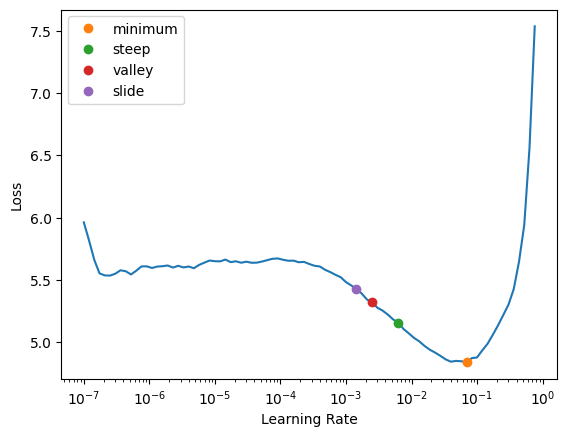

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fit_one_cycle(15, 0.006)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.648130,2.319698,0.404177,0.595823,02:09
1,2.237278,1.810643,0.511056,0.488943,02:05
2,1.714782,1.680650,0.550983,0.449017,01:59
3,1.531793,1.720166,0.559582,0.440418,02:01
4,1.240509,1.782564,0.562654,0.437346,01:58
5,1.032528,1.311262,0.649877,0.350123,01:59
6,0.793573,1.336486,0.652334,0.347666,01:59
7,0.639029,1.027560,0.704545,0.295455,02:01
8,0.471499,1.078041,0.715602,0.284398,01:59
9,0.305101,0.851792,0.772727,0.227273,01:59


In [ ]:
learn.export('224_resnet50_freeze.pkl')

In [ ]:
learn.save('224_resnet50_freeze')
learn.load('224_resnet50_freeze')

## Fine-tuning без Data Augmentation

In [ ]:
learn.unfreeze()

SuggestedLRs(minimum=2.7542287170945203e-07, steep=1.0964781722577754e-06, valley=1.3182567499825382e-06, slide=1.737800812406931e-05)

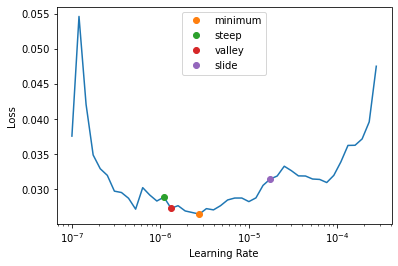

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fit_one_cycle(15, 1.1e-6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.031678,0.771878,0.811425,0.188575,02:13
1,0.032688,0.775515,0.808968,0.191032,02:11
2,0.034916,0.770017,0.813268,0.186732,02:12
3,0.031572,0.767083,0.812039,0.187961,02:11
4,0.026256,0.764144,0.809582,0.190418,02:14
5,0.026591,0.767041,0.807740,0.192260,02:12
6,0.024722,0.761617,0.808354,0.191646,02:12
7,0.022889,0.762171,0.813882,0.186118,02:11
8,0.020254,0.758269,0.807740,0.192260,02:13
9,0.021711,0.758982,0.810197,0.189803,02:11


In [ ]:
learn.save('224_resnet50_unfreeze')

Path('cardata/models/224_resnet50_unfreeze.pth')

Полученная точность в ходе эксперимента 81%.
Сохранение на диск нейронной сети:

In [ ]:
# uploaded = drive.CreateFile({'title': '224_resnet50_ufreeze_da.pth'})
# uploaded.SetContentFile('cardata/models/224_resnet50_unfreeze.pth')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

FileNotFoundError: ignored

## TL c Data Augmentation

Применение трансформаций к batch ведет к увеличению объема данных (data augmenation)

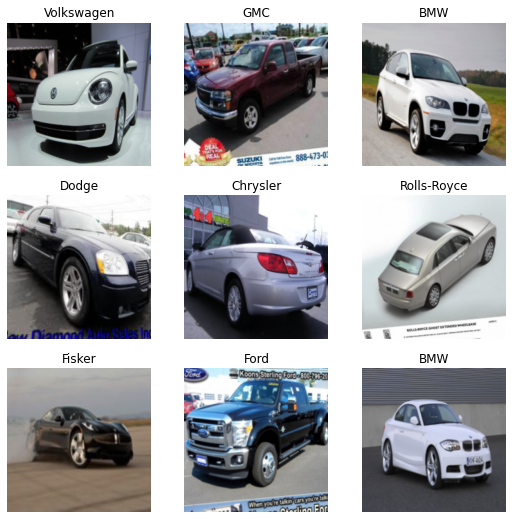

In [ ]:
# функция для получения данных с нужным размером
def get_data(sz):
    item_tfms = [ Resize(sz, method='squish') ]
    batch_tfms = aug_transforms(size=sz, do_flip=False)
    return ImageDataLoaders.from_csv(PATH, csv_fname='train.csv',
                                     folder='cars_train', val_idxs=val_idxs,
                                     item_tfms=item_tfms, batch_tfms=batch_tfms)
    
sz = 224
data = get_data(sz) 
data.show_batch()

In [ ]:
learn = vision_learner(data, models.resnet50, metrics=[accuracy, error_rate])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.005754399299621582, steep=0.005248074419796467, valley=0.0006918309954926372, slide=0.001737800776027143)

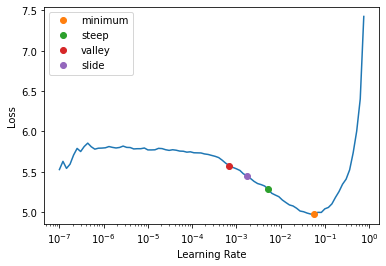

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fit_one_cycle(15, 0.011)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.407610,2.349977,0.415848,0.584152,02:04
1,2.208655,2.153560,0.485258,0.514742,02:04
2,2.081896,2.745533,0.407862,0.592138,02:02
3,1.876802,2.100842,0.490172,0.509828,02:03
4,1.502345,1.577479,0.568796,0.431204,02:02
5,1.279301,1.925606,0.538084,0.461916,02:02
6,1.150559,1.335275,0.644349,0.355651,02:02
7,0.988081,1.161956,0.677518,0.322482,02:03
8,0.825552,1.080616,0.695332,0.304668,02:03
9,0.632103,0.797763,0.777027,0.222973,02:03


In [ ]:
learn.save('224_resnet50_freeze_data_aug')
learn.load('224_resnet50_freeze_data_aug')

## Fine-tuning c Data Augmentation

SuggestedLRs(minimum=7.585775847473997e-08, steep=6.309573450380412e-07, valley=1.4454397387453355e-05, slide=2.0892961401841603e-05)

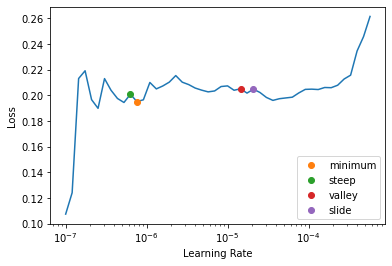

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fit_one_cycle(15, 6.31e-7)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.197754,0.604922,0.834767,0.165233,02:08
1,0.207517,0.610212,0.832924,0.167076,02:08
2,0.204234,0.608945,0.830467,0.169533,02:09
3,0.210418,0.602533,0.837838,0.162162,02:10
4,0.191020,0.600415,0.834767,0.165233,02:11
5,0.200649,0.597065,0.837838,0.162162,02:10
6,0.191927,0.599574,0.835381,0.164619,02:11
7,0.197340,0.598314,0.831081,0.168919,02:10
8,0.196886,0.596285,0.840295,0.159705,02:09
9,0.188362,0.593404,0.835995,0.164005,02:10


In [ ]:
learn.save('224_resnet50_unfreeze_data_aug')

Полученная точность в ходе эксперимента 84%.

## Fine-tuning c Data Augmentation и Differential Learning Rates.

In [ ]:
learn.load('224_resnet50_freeze_data_aug')

In [ ]:
learn.unfreeze()

SuggestedLRs(minimum=9.120108734350651e-06, steep=6.309573450380412e-07, valley=2.0892961401841603e-05, slide=9.999999747378752e-06)

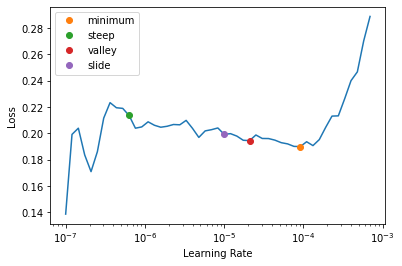

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = 6.31e-07
lrs = np.array([lr/9, lr/3, lr])

In [ ]:
learn.fit_one_cycle(15, lrs)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.207671,0.610069,0.831695,0.168305,02:10
1,0.200902,0.608510,0.830467,0.169533,02:10
2,0.211595,0.603429,0.832924,0.167076,02:08
3,0.212079,0.606779,0.830467,0.169533,02:10
4,0.210013,0.604336,0.837224,0.162776,02:09
5,0.201193,0.611026,0.832310,0.167690,02:11
6,0.194779,0.599016,0.834767,0.165233,02:10
7,0.207844,0.597061,0.835995,0.164005,02:10
8,0.208396,0.602141,0.829853,0.170147,02:08
9,0.186590,0.609780,0.833538,0.166462,02:10


In [ ]:
learn.save('224_resnet50_unfreeze_data_aug_dlrs')

Path('cardata/models/224_resnet50_unfreeze_data_aug_dlrs.pth')

##!!! Fine-tuning c Data Augmentation и Learning Rate Annealing.

In [ ]:
learn = vision_learner(data, models.resnet50, metrics=[accuracy, error_rate])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 290MB/s]


In [ ]:
learn.load('224_resnet50_freeze_data_aug')

FileNotFoundError: ignored

In [ ]:
learn.unfreeze()

SuggestedLRs(minimum=9.120108734350651e-06, steep=9.12010818865383e-07, valley=2.0892961401841603e-05, slide=9.999999747378752e-06)

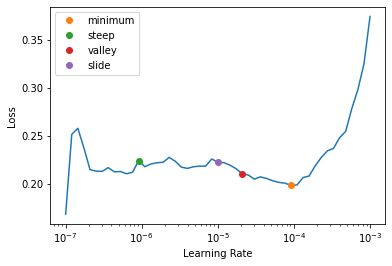

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = 9.12e-07
lrs = np.array([lr/9, lr/3, lr])

In [ ]:
learn.fit_sgdr(15, cycle_len=1, lr_max=lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.204307,0.605886,0.832310,0.167690,02:10
1,0.198038,0.607123,0.835995,0.164005,02:19
2,0.198367,0.605188,0.832310,0.167690,02:11
3,0.194933,0.591446,0.836609,0.163391,02:08
4,0.188735,0.595695,0.837224,0.162776,02:08
5,0.191926,0.591349,0.837224,0.162776,02:08
6,0.191700,0.588492,0.836609,0.163391,02:08
7,0.194364,0.593812,0.837838,0.162162,02:04
8,0.199499,0.588348,0.837224,0.162776,02:05
9,0.181101,0.582190,0.839066,0.160934,02:03


In [ ]:
learn.save('224_resnet50_unfreeze_data_aug_dlrs_lra')

## Fine-tuning c Data Augmentation и Cyclic Learning Rate Annealing

In [ ]:
learn = vision_learner(data, models.resnet50, metrics=[accuracy, error_rate])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 

In [ ]:
learn.load('224_resnet50_freeze_data_aug')

In [ ]:
learn.unfreeze()

SuggestedLRs(minimum=9.12010818865383e-08, steep=3.311311274956097e-06, valley=6.30957365501672e-05, slide=2.511886486900039e-05)

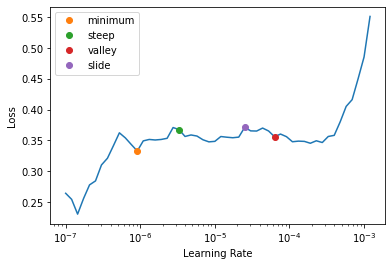

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = 7.6e-07
lrs = np.array([lr/9, lr/3, lr])

In [ ]:
learn.fit_sgdr(5, 1, lrs, cycle_mult=2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.315460,0.170634,0.953317,0.046683,02:08
1,0.316127,0.170885,0.957617,0.042383,02:07
2,0.320987,0.174725,0.957002,0.042998,02:09
3,0.296990,0.171680,0.955160,0.044840,02:07
4,0.324080,0.171795,0.955774,0.044226,02:06
5,0.297355,0.173360,0.953931,0.046069,02:05
6,0.317453,0.172795,0.955774,0.044226,02:09
7,0.306917,0.171646,0.952703,0.047297,02:06
8,0.305409,0.172282,0.952703,0.047297,02:04
9,0.307861,0.169627,0.955160,0.044840,02:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.315460,0.170634,0.953317,0.046683,02:08
1,0.316127,0.170885,0.957617,0.042383,02:07
2,0.320987,0.174725,0.957002,0.042998,02:09
3,0.296990,0.171680,0.955160,0.044840,02:07
4,0.324080,0.171795,0.955774,0.044226,02:06
5,0.297355,0.173360,0.953931,0.046069,02:05
6,0.317453,0.172795,0.955774,0.044226,02:09
7,0.306917,0.171646,0.952703,0.047297,02:06
8,0.305409,0.172282,0.952703,0.047297,02:04
9,0.307861,0.169627,0.955160,0.044840,02:04


In [ ]:
learn.save('224_resnet50_unfreeze_da_dlrs_lra_mult')

Path('cardata/models/224_resnet50_unfreeze_da_dlrs_lra_mult.pth')

## Замерчики

In [ ]:
sz = 224
item_tfms = [ Resize(sz) ]
data = ImageDataLoaders.from_csv(PATH, csv_fname='test.csv',
                                     folder='cars_test', val_idxs=val_idxs,
                                     item_tfms=item_tfms)
#data.show_batch()

learn = vision_learner(data, models.resnet50)
learn.load('224_resnet50_freeze_data_aug')
learn.unfreeze()
learn.load('224_resnet50_unfreeze_da_dlrs_lra_mult')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


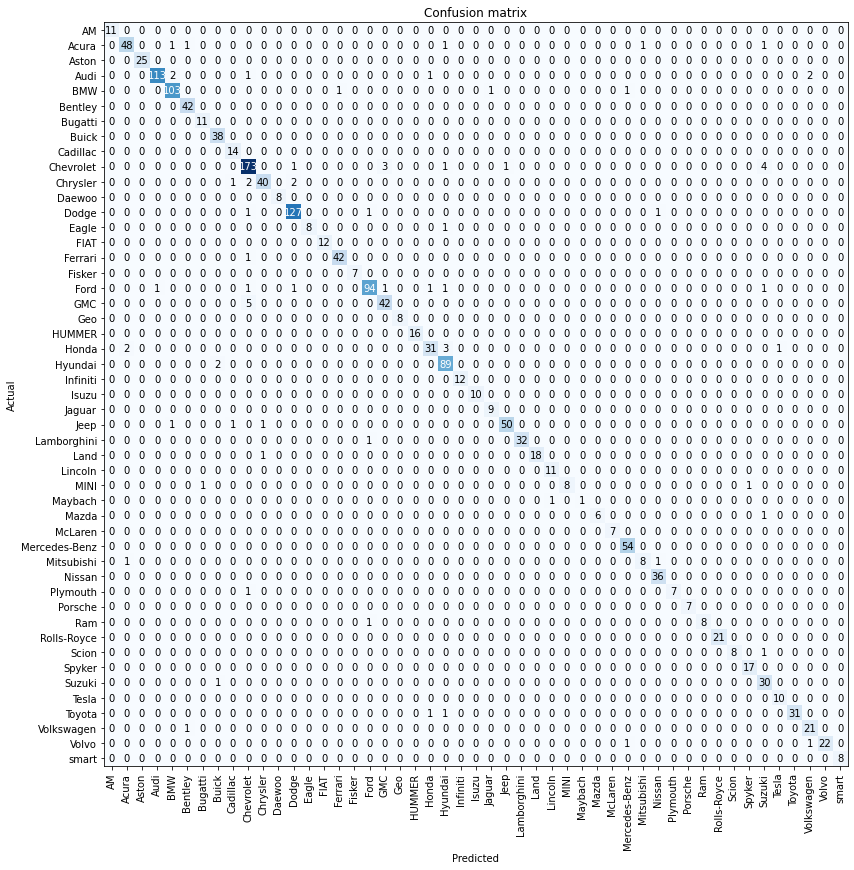

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12))

In [ ]:
interp.most_confused()

[('GMC', 'Chevrolet', 5),
 ('Chevrolet', 'Suzuki', 4),
 ('Chevrolet', 'GMC', 3),
 ('Honda', 'Hyundai', 3),
 ('Audi', 'BMW', 2),
 ('Audi', 'Volkswagen', 2),
 ('Chrysler', 'Chevrolet', 2),
 ('Chrysler', 'Dodge', 2),
 ('Honda', 'Acura', 2),
 ('Hyundai', 'Buick', 2),
 ('Acura', 'BMW', 1),
 ('Acura', 'Bentley', 1),
 ('Acura', 'Hyundai', 1),
 ('Acura', 'Mitsubishi', 1),
 ('Acura', 'Suzuki', 1),
 ('Audi', 'Chevrolet', 1),
 ('Audi', 'Honda', 1),
 ('BMW', 'Ferrari', 1),
 ('BMW', 'Jaguar', 1),
 ('BMW', 'Mercedes-Benz', 1),
 ('Chevrolet', 'Dodge', 1),
 ('Chevrolet', 'Hyundai', 1),
 ('Chevrolet', 'Jeep', 1),
 ('Chrysler', 'Cadillac', 1),
 ('Dodge', 'Chevrolet', 1),
 ('Dodge', 'Ford', 1),
 ('Dodge', 'Nissan', 1),
 ('Eagle', 'Hyundai', 1),
 ('Ferrari', 'Chevrolet', 1),
 ('Ford', 'Audi', 1),
 ('Ford', 'Chevrolet', 1),
 ('Ford', 'Dodge', 1),
 ('Ford', 'GMC', 1),
 ('Ford', 'Honda', 1),
 ('Ford', 'Hyundai', 1),
 ('Ford', 'Suzuki', 1),
 ('Honda', 'Tesla', 1),
 ('Jeep', 'BMW', 1),
 ('Jeep', 'Cadillac', 1)

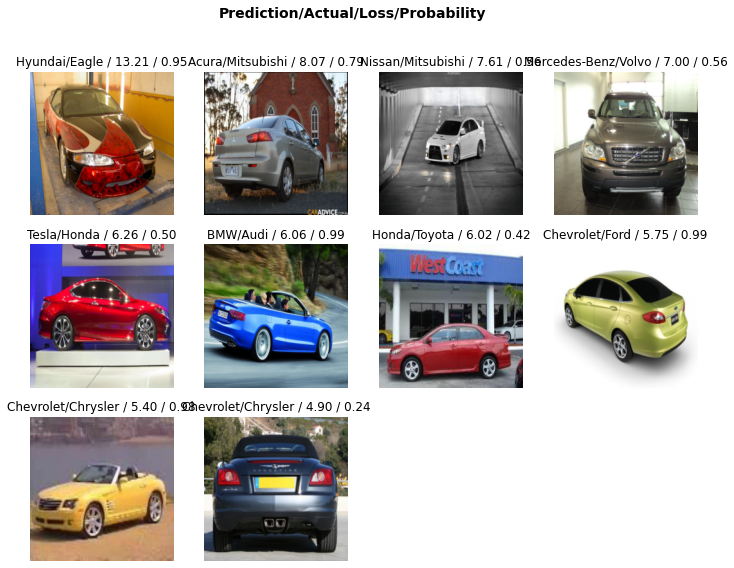

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(10)

In [ ]:
log_preds, labels = learn.get_preds()

In [ ]:
correct_predictions = torch.eq(torch.argmax(log_preds, dim=1), labels).sum().item()

In [ ]:
total_predictions = len(labels)

In [ ]:
accuracy = correct_predictions / total_predictions
accuracy

0.9545454545454546

In [ ]:
tta_log_preds, y_tta = learn.tta()

In [ ]:
tta_correct_predictions = torch.eq(torch.argmax(tta_log_preds, dim=1), y_tta).sum().item()

In [ ]:
accuracy = tta_correct_predictions / total_predictions
accuracy

0.9692874692874693

In [ ]:
img = Image.open('cardata/focus.jpg')

In [ ]:
img = img.resize((224,224))

In [ ]:
prediction,_,_ = learn.predict(img)

In [ ]:
prediction

'Hyundai'

# Тестирование полученных моделей

## Common

In [ ]:
sz = 224
item_tfms = [ Resize(sz) ]
test_data = ImageDataLoaders.from_csv(PATH, csv_fname='test.csv',
                                     folder='cars_test', val_idxs=val_idxs,
                                     item_tfms=item_tfms)

In [ ]:
# Функция замеров точности на тестовом датасете
def testing(learner):
  log_preds, labels = learner.get_preds()
  correct_predictions = torch.eq(torch.argmax(log_preds, dim=1), labels).sum().item()
  total_predictions = len(labels)
  accuracy = correct_predictions / total_predictions
  tta_log_preds, y_tta = learner.tta()
  tta_correct_predictions = torch.eq(torch.argmax(tta_log_preds, dim=1), y_tta).sum().item()
  tta_accuracy = tta_correct_predictions / total_predictions
  return accuracy, tta_accuracy

## Transfer Learning

In [ ]:
TL_learn = vision_learner(test_data, models.resnet50)
TL_learn.load('224_resnet50_freeze')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
TL_accuracy, TL_tta_accuracy = testing(TL_learn)

In [ ]:
print(TL_accuracy)
print(TL_tta_accuracy)

0.6946517412935324
0.7319651741293532


## Fine tuning

In [ ]:
FT_learn = vision_learner(test_data, models.resnet50)
FT_learn.load('224_resnet50_unfreeze')

In [ ]:
FT_accuracy, FT_tta_accuracy = testing(FT_learn)

In [ ]:
print(FT_accuracy)
print(FT_tta_accuracy)

0.6958955223880597
0.7350746268656716


## Data augmentation

In [ ]:
DA_learn = vision_learner(test_data, models.resnet50)
DA_learn.load('224_resnet50_unfreeze_data_aug')

In [ ]:
DA_accuracy, DA_tta_accuracy = testing(DA_learn)

In [ ]:
print(DA_accuracy)
print(DA_tta_accuracy)

0.746268656716418
0.7860696517412935


## Differential Learning Rates

In [ ]:
DLR_learn = vision_learner(test_data, models.resnet50)
DLR_learn.load('224_resnet50_unfreeze_data_aug_dlrs')

In [ ]:
DLR_accuracy, DLR_tta_accuracy = testing(DLR_learn)

In [ ]:
print(DLR_accuracy)
print(DLR_tta_accuracy)

0.7412935323383084
0.7767412935323383


##!!! Learning rates annealing

In [ ]:
#LRA_learn = vision_learner(test_data, models.resnet50)
#LRA_learn.load('224_resnet50_unfreeze_data_aug_dlrs_lra_mult')

## Cyclic Learning rate annealing

In [ ]:
CLRA_learn = vision_learner(test_data, models.resnet50)
CLRA_learn.load('224_resnet50_unfreeze_da_dlrs_lra_mult')

In [ ]:
CLRA_accuracy, CLRA_tta_accuracy = testing(CLRA_learn)

In [ ]:
print(CLRA_accuracy)
print(CLRA_tta_accuracy)

0.7419154228855721
0.7823383084577115


# Improving

## Common

In [ ]:
def get_data(sz:int=299, is_testing:bool=False):
    item_tfms = [ Resize(sz, method='squish') ]
    batch_tfms = aug_transforms(size=sz, do_flip=False)
  
  #, Normalize.from_stats(imagenet_stats, imagenet_stats)]

    csv_name = 'train.csv'
    our_folder = 'cars_train'
  
    if is_testing:
      csv_name = 'test.csv'
      our_folder = 'cars_test'

    return ImageDataLoaders.from_csv(PATH, csv_fname=csv_name,
                                     folder=our_folder, val_idxs=val_idxs,
                                     item_tfms=item_tfms, batch_tfms=batch_tfms)
    
sz = 299

train_data = get_data(sz)
test_data = get_data(sz, True)

In [ ]:
def testing(learner):
  log_preds, labels = learner.get_preds()
  correct_predictions = torch.eq(torch.argmax(log_preds, dim=1), labels).sum().item()
  total_predictions = len(labels)
  accuracy = correct_predictions / total_predictions
  tta_log_preds, y_tta = learner.tta()
  tta_correct_predictions = torch.eq(torch.argmax(tta_log_preds, dim=1), y_tta).sum().item()
  tta_accuracy = tta_correct_predictions / total_predictions
  return accuracy, tta_accuracy

In [ ]:
train_data.batch_size = 16
test_data.batch_size = 16

In [ ]:
i_learn = vision_learner(train_data, models.resnet50, metrics=accuracy)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [ ]:
i_learn_test = vision_learner(test_data, models.resnet50)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Stage 1

SuggestedLRs(valley=0.0014454397605732083)

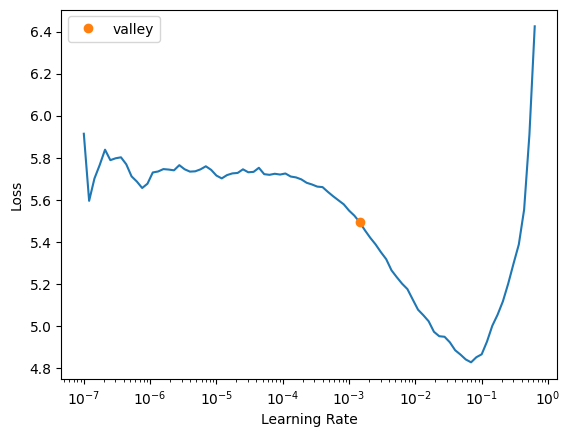

In [ ]:
i_learn.lr_find()

In [ ]:
i_learn.fit_one_cycle(15, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.526647,2.383791,0.383907,02:23
1,2.371631,1.900678,0.471744,02:18
2,1.906553,1.561827,0.561425,02:17


epoch,train_loss,valid_loss,accuracy,time
0,3.526647,2.383791,0.383907,02:23
1,2.371631,1.900678,0.471744,02:18
2,1.906553,1.561827,0.561425,02:17
3,1.518177,1.229625,0.648649,02:17
4,1.184275,1.110095,0.683661,02:18
5,0.923652,1.042476,0.700860,02:18
6,0.785401,0.958468,0.731573,02:18
7,0.693927,0.803647,0.775184,02:17
8,0.538760,0.786268,0.778870,02:17
9,0.405886,0.747498,0.792998,02:17


In [ ]:
i_learn.save('299_resnet_improved_stage1-80')

Path('cardata/models/299_resnet_improved_stage1-80.pth')

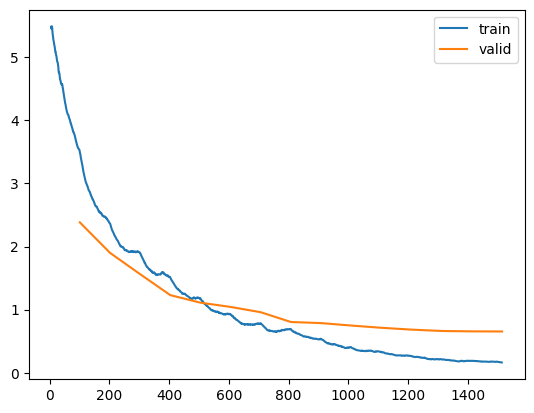

In [ ]:
i_learn.recorder.plot_loss()

## Stage 2 (Unfreeze)

In [ ]:
i_learn.load('299_resnet_improved_stage1-80')
i_learn.unfreeze()

SuggestedLRs(valley=1.2022644114040304e-05)

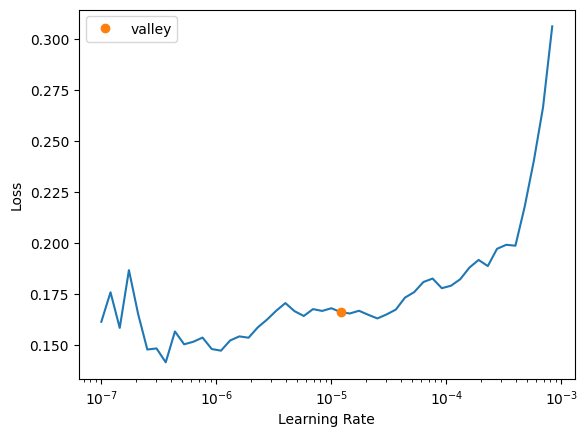

In [ ]:
i_learn.lr_find()

In [ ]:
lrs = [3e-3/100, 3e-3/20, 3e-3/10]
i_learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.193558,0.668927,0.816953,02:34


epoch,train_loss,valid_loss,accuracy,time
0,0.193558,0.668927,0.816953,02:34
1,0.396477,1.212039,0.708231,02:30
2,0.417020,0.785629,0.788084,02:28
3,0.290859,0.717571,0.817568,02:29
4,0.206328,0.552465,0.846437,02:29
5,0.122761,0.487717,0.859337,02:29
6,0.079003,0.398540,0.882678,02:28
7,0.057695,0.380961,0.887592,02:29
8,0.032586,0.359138,0.887592,02:28


KeyboardInterrupt: ignored

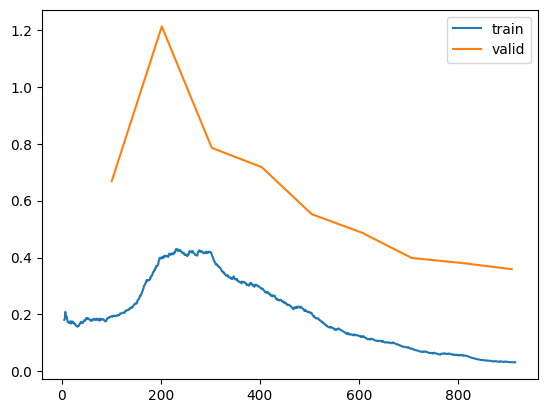

In [ ]:
i_learn.save('299_resnet_improved_stage2-80')
i_learn.recorder.plot_loss()

## Stage 3

SuggestedLRs(valley=1.4454397387453355e-05)

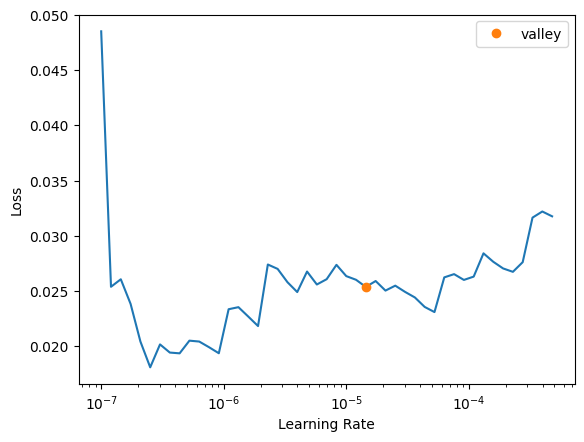

In [ ]:
i_learn.lr_find()

In [ ]:
i_learn.load('299_resnet_improved_stage2-80')
i_learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.028191,0.355441,0.891892,02:38
1,0.025764,0.346892,0.895577,02:37
2,0.020089,0.338857,0.897420,02:36
3,0.019340,0.328009,0.900491,02:32


epoch,train_loss,valid_loss,accuracy,time
0,0.028191,0.355441,0.891892,02:38
1,0.025764,0.346892,0.895577,02:37
2,0.020089,0.338857,0.897420,02:36
3,0.019340,0.328009,0.900491,02:32
4,0.015325,0.333182,0.899263,02:30
5,0.015439,0.328758,0.903563,02:29


KeyboardInterrupt: ignored

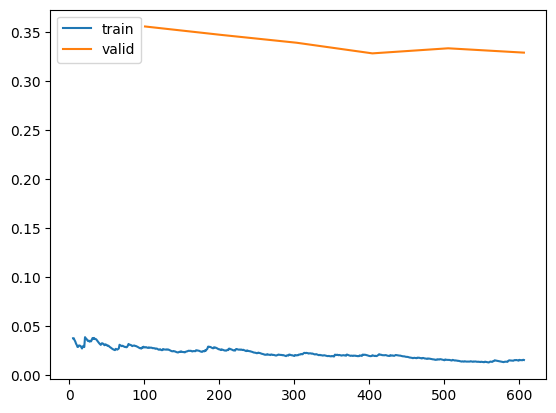

In [ ]:
i_learn.save('299_resnet_improved_stage3-90')
i_learn.recorder.plot_loss()

## Замеры улучшенной модели

In [ ]:
i_learn_test.load('299_resnet_improved_stage3-90')
testing(i_learn_test)

(0.9166666666666666, 0.9235074626865671)

In [ ]:
img = Image.open('cardata/bwm.jpeg')

In [ ]:
img = img.resize((299,299))

In [ ]:
prediction,_,_ = i_learn_test.predict(img)

In [ ]:
prediction

'Tesla'

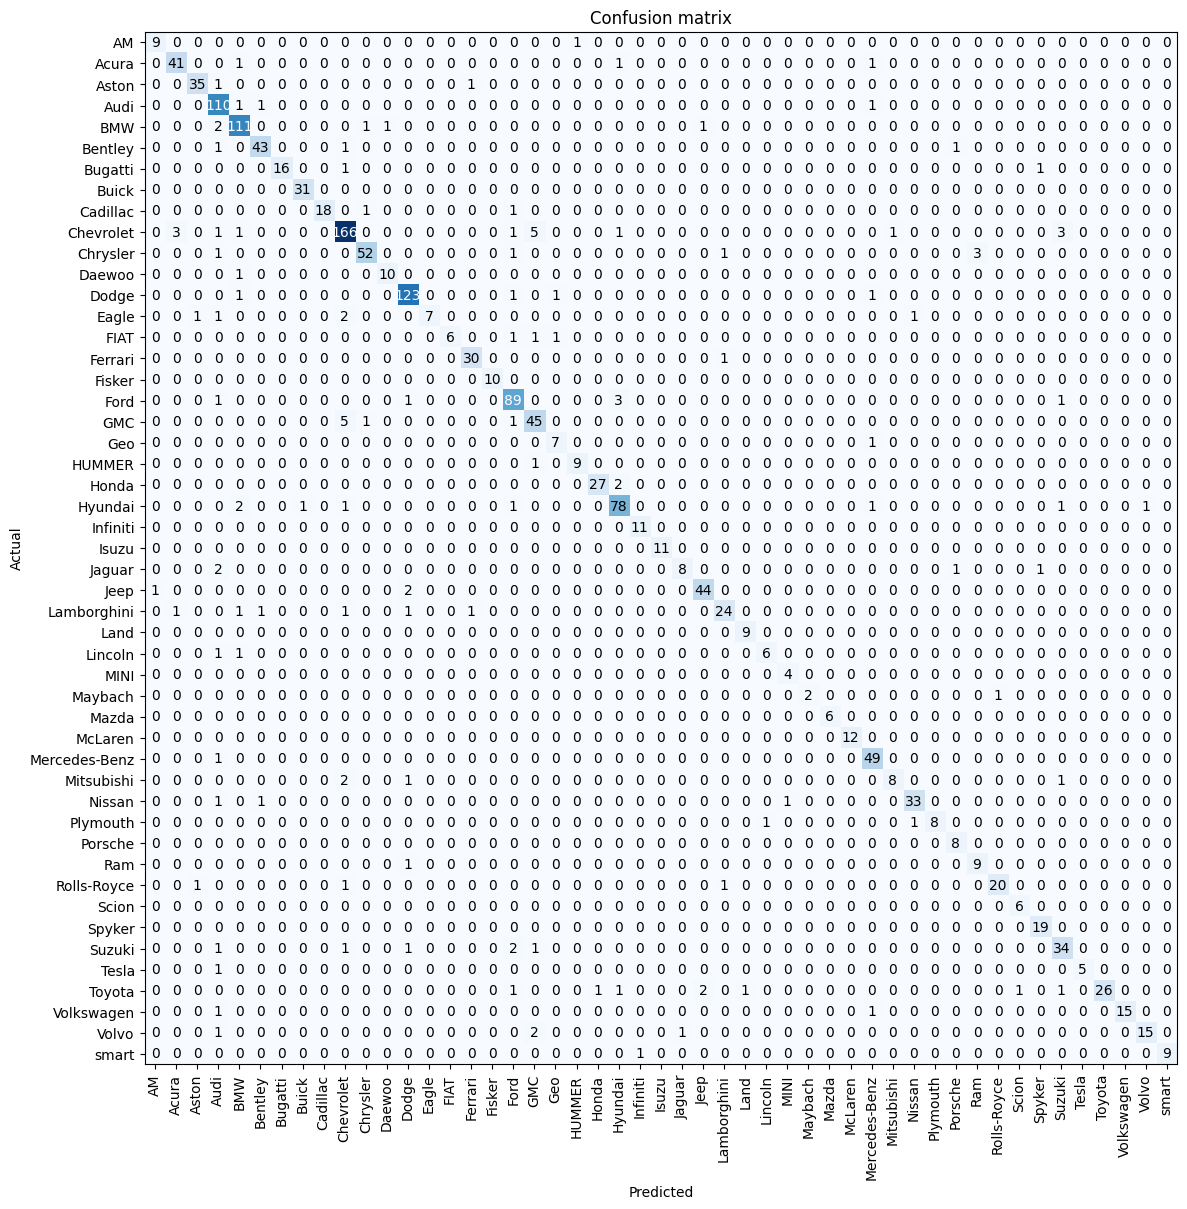

In [ ]:
interp = ClassificationInterpretation.from_learner(i_learn_test)
interp.plot_confusion_matrix(figsize=(12,12))

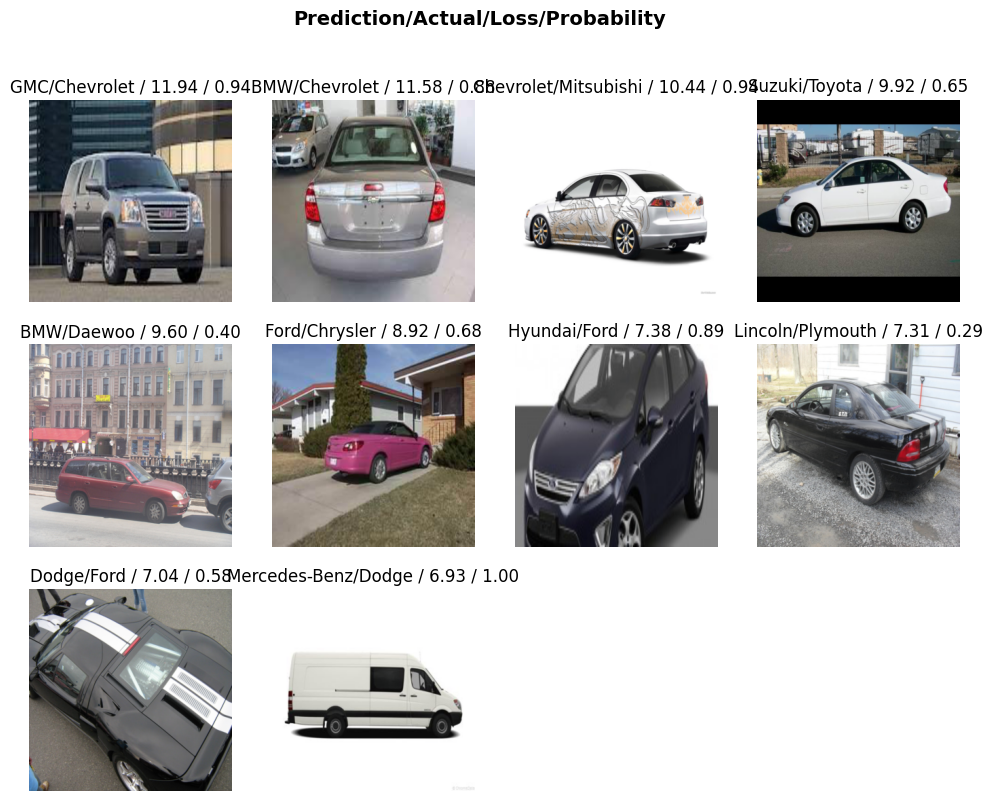

In [ ]:
interp = Interpretation.from_learner(i_learn_test)
interp.plot_top_losses(10)

## Экспорт

In [ ]:
i_learn_test.export('resnet299.pkl')

In [ ]:
from google.colab import files

In [ ]:
files.download('cardata/resnet299.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('cardata/models/299_resnet_improved_stage3-90.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('cardata/models/299_resnet_improved_stage2-80.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>